# Principle Component Analysis

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("/Users/benchen/NeuralHub/Neuromatch/NM_DL_custom_plot_style.mplstyle")

In [4]:
# @title Plotting Functions

def plot_eigenvalues(evals):
  """
  Plots eigenvalues.

  Args:
      (numpy array of floats) : Vector of eigenvalues

  Returns:
    Nothing.

  """
  plt.figure(figsize=(4, 4))
  plt.plot(np.arange(1, len(evals) + 1), evals, 'o-k')
  plt.xlabel('Component')
  plt.ylabel('Eigenvalue')
  plt.title('Scree plot')
  plt.xticks(np.arange(1, len(evals) + 1))
  plt.ylim([0, 2.5])
  plt.show()


def plot_data(X):
  """
  Plots bivariate data. Includes a plot of each random variable, and a scatter
  scatter plot of their joint activity. The title indicates the sample
  correlation calculated from the data.

  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable

  Returns:
    Nothing.
  """

  fig = plt.figure(figsize=[8, 4])
  gs = fig.add_gridspec(2, 2)
  ax1 = fig.add_subplot(gs[0, 0])
  ax1.plot(X[:, 0], color='k')
  plt.ylabel('Neuron 1')
  ax2 = fig.add_subplot(gs[1, 0])
  ax2.plot(X[:, 1], color='k')
  plt.xlabel('Sample Number (sorted)')
  plt.ylabel('Neuron 2')
  ax3 = fig.add_subplot(gs[:, 1])
  ax3.plot(X[:, 0], X[:, 1], '.', markerfacecolor=[.5, .5, .5],
           markeredgewidth=0)
  ax3.axis('equal')
  plt.xlabel('Neuron 1 activity')
  plt.ylabel('Neuron 2 activity')
  plt.title('Sample corr: {:.1f}'.format(np.corrcoef(X[:, 0], X[:, 1])[0, 1]))
  plt.show()


def plot_data_new_basis(Y):
  """
  Plots bivariate data after transformation to new bases. Similar to plot_data
  but with colors corresponding to projections onto basis 1 (red) and
  basis 2 (blue).
  The title indicates the sample correlation calculated from the data.

  Note that samples are re-sorted in ascending order for the first random
  variable.

  Args:
    Y (numpy array of floats) : Data matrix in new basis each column
                                corresponds to a different random variable

  Returns:
    Nothing.
  """

  fig = plt.figure(figsize=[8, 4])
  gs = fig.add_gridspec(2, 2)
  ax1 = fig.add_subplot(gs[0, 0])
  ax1.plot(Y[:, 0], 'r')
  plt.ylabel('Projection \n basis vector 1')
  ax2 = fig.add_subplot(gs[1, 0])
  ax2.plot(Y[:, 1], 'b')
  plt.xlabel('Sample number')
  plt.ylabel('Projection \n basis vector 2')
  ax3 = fig.add_subplot(gs[:, 1])
  ax3.plot(Y[:, 0], Y[:, 1], '.', color=[.5, .5, .5])
  ax3.axis('equal')
  plt.xlabel('Projection basis vector 1')
  plt.ylabel('Projection basis vector 2')
  plt.title('Sample corr: {:.1f}'.format(np.corrcoef(Y[:, 0], Y[:, 1])[0, 1]))
  plt.show()


def plot_basis_vectors(X, W):
  """
  Plots bivariate data as well as new basis vectors.

  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable
    W (numpy array of floats) : Square matrix representing new orthonormal
                                basis each column represents a basis vector

  Returns:
    Nothing.
  """

  plt.figure(figsize=[4, 4])
  plt.plot(X[:, 0], X[:, 1], '.', color=[.5, .5, .5], label='Data')
  plt.axis('equal')
  plt.xlabel('Neuron 1 activity')
  plt.ylabel('Neuron 2 activity')
  plt.plot([0, W[0, 0]], [0, W[1, 0]], color='r', linewidth=3,
           label='Basis vector 1')
  plt.plot([0, W[0, 1]], [0, W[1, 1]], color='b', linewidth=3,
           label='Basis vector 2')
  plt.legend()
  plt.show()

In [5]:
# @title Helper functions

def sort_evals_descending(evals, evectors):
  """
  Sorts eigenvalues and eigenvectors in decreasing order. Also aligns first two
  eigenvectors to be in first two quadrants (if 2D).

  Args:
    evals (numpy array of floats)    : Vector of eigenvalues
    evectors (numpy array of floats) : Corresponding matrix of eigenvectors
                                        each column corresponds to a different
                                        eigenvalue

  Returns:
    (numpy array of floats)          : Vector of eigenvalues after sorting
    (numpy array of floats)          : Matrix of eigenvectors after sorting
  """

  index = np.flip(np.argsort(evals))
  evals = evals[index]
  evectors = evectors[:, index]
  if evals.shape[0] == 2:
    if np.arccos(np.matmul(evectors[:, 0],
                           1 / np.sqrt(2) * np.array([1, 1]))) > np.pi / 2:
      evectors[:, 0] = -evectors[:, 0]
    if np.arccos(np.matmul(evectors[:, 1],
                           1 / np.sqrt(2) * np.array([-1, 1]))) > np.pi / 2:
      evectors[:, 1] = -evectors[:, 1]
  return evals, evectors


def get_data(cov_matrix):
  """
  Returns a matrix of 1000 samples from a bivariate, zero-mean Gaussian

  Note that samples are sorted in ascending order for the first random
  variable.

  Args:
    var_1 (scalar)                     : variance of the first random variable
    var_2 (scalar)                     : variance of the second random variable
    cov_matrix (numpy array of floats) : desired covariance matrix

  Returns:
    (numpy array of floats)            : samples from the bivariate Gaussian,
                                          with each column corresponding to a
                                          different random variable
  """

  mean = np.array([0, 0])
  X = np.random.multivariate_normal(mean, cov_matrix, size=1000)
  indices_for_sorting = np.argsort(X[:, 0])
  X = X[indices_for_sorting, :]
  return X


def calculate_cov_matrix(var_1, var_2, corr_coef):
  """
  Calculates the covariance matrix based on the variances and
  correlation coefficient.

  Args:
    var_1 (scalar)         :  variance of the first random variable
    var_2 (scalar)         :  variance of the second random variable
    corr_coef (scalar)     :  correlation coefficient

  Returns:
    (numpy array of floats) : covariance matrix
  """
  cov = corr_coef * np.sqrt(var_1 * var_2)
  cov_matrix = np.array([[var_1, cov], [cov, var_2]])
  return cov_matrix


def define_orthonormal_basis(u):
  """
  Calculates an orthonormal basis given an arbitrary vector u.

  Args:
    u (numpy array of floats) : arbitrary 2D vector used for new basis

  Returns:
    (numpy array of floats)   : new orthonormal basis columns correspond to
                                basis vectors
  """

  u = u / np.sqrt(u[0] ** 2 + u[1] ** 2)
  w = np.array([-u[1], u[0]])
  W = np.column_stack((u, w))
  return W


def change_of_basis(X, W):
  """
  Projects data onto a new basis.

  Args:
    X (numpy array of floats) : Data matrix each column corresponding to a
                                different random variable
    W (numpy array of floats) : new orthonormal basis columns correspond to
                                basis vectors

  Returns:
    (numpy array of floats)   : Data matrix expressed in new basis
  """

  Y = np.matmul(X, W)
  return Y

**Important features of PCA and covariance matrix**<br>
* The varianve described by the eigenvalues calculated from the covariance matrix is simply measured by the value of that eigenvalue
* The principle components are the eigenvectors caclulated from the covariance matrix, the first principle component is the eigenvector with the largest corresponding eigenvalue.


**PCA Algorithm**<br>
1. Subtract the mean
2. Calclulate the eigenvectors w_i of the covariance matrix, ordered by their corresponding eignevealue lambda_i
3. Project the data X onto the new basis w_1, w_2, ..., w_n

### Intuition
Eigenvectors are defined as Ax = lambda * x, for a n by n matrix. Thus, it can also be interepted as a possible vector that the whole matrix can be projected onto. 


## Calculating the covariance matrix
1. Subtract the mean
2. 1/N * X.T X
3. Compare with the true covariate matrix

In [6]:
help(get_data)
help(calculate_cov_matrix)

Help on function get_data in module __main__:

get_data(cov_matrix)
    Returns a matrix of 1000 samples from a bivariate, zero-mean Gaussian
    
    Note that samples are sorted in ascending order for the first random
    variable.
    
    Args:
      var_1 (scalar)                     : variance of the first random variable
      var_2 (scalar)                     : variance of the second random variable
      cov_matrix (numpy array of floats) : desired covariance matrix
    
    Returns:
      (numpy array of floats)            : samples from the bivariate Gaussian,
                                            with each column corresponding to a
                                            different random variable

Help on function calculate_cov_matrix in module __main__:

calculate_cov_matrix(var_1, var_2, corr_coef)
    Calculates the covariance matrix based on the variances and
    correlation coefficient.
    
    Args:
      var_1 (scalar)         :  variance of the first ran

In [7]:
def get_sample_cov_matrix(X):
  """
  Returns the sample covariance matrix of data X

  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable

  Returns:
    (numpy array of floats)   : Covariance matrix
  """

  # Subtract the mean of X
  X = X - np.mean(X)

  # Calculate the covariance matrix (hint: use np.matmul)
  cov_matrix = (1/(len(X))) * np.matmul(X.T, X) # np.matmul does matrix multiplication

  return cov_matrix


# Set parameters
np.random.seed(2020)  # set random seed
variance_1 = 1
variance_2 = 1
corr_coef = 0.8

# Calculate covariance matrix
cov_matrix = calculate_cov_matrix(variance_1, variance_2, corr_coef)
print(cov_matrix)

# Generate data with that covariance matrix
X = get_data(cov_matrix)

# Get sample covariance matrix
sample_cov_matrix = get_sample_cov_matrix(X)
print(sample_cov_matrix)

[[1.  0.8]
 [0.8 1. ]]
[[0.99316457 0.82346444]
 [0.82346444 1.01282542]]


In [8]:
help(sort_evals_descending)

Help on function sort_evals_descending in module __main__:

sort_evals_descending(evals, evectors)
    Sorts eigenvalues and eigenvectors in decreasing order. Also aligns first two
    eigenvectors to be in first two quadrants (if 2D).
    
    Args:
      evals (numpy array of floats)    : Vector of eigenvalues
      evectors (numpy array of floats) : Corresponding matrix of eigenvectors
                                          each column corresponds to a different
                                          eigenvalue
    
    Returns:
      (numpy array of floats)          : Vector of eigenvalues after sorting
      (numpy array of floats)          : Matrix of eigenvectors after sorting



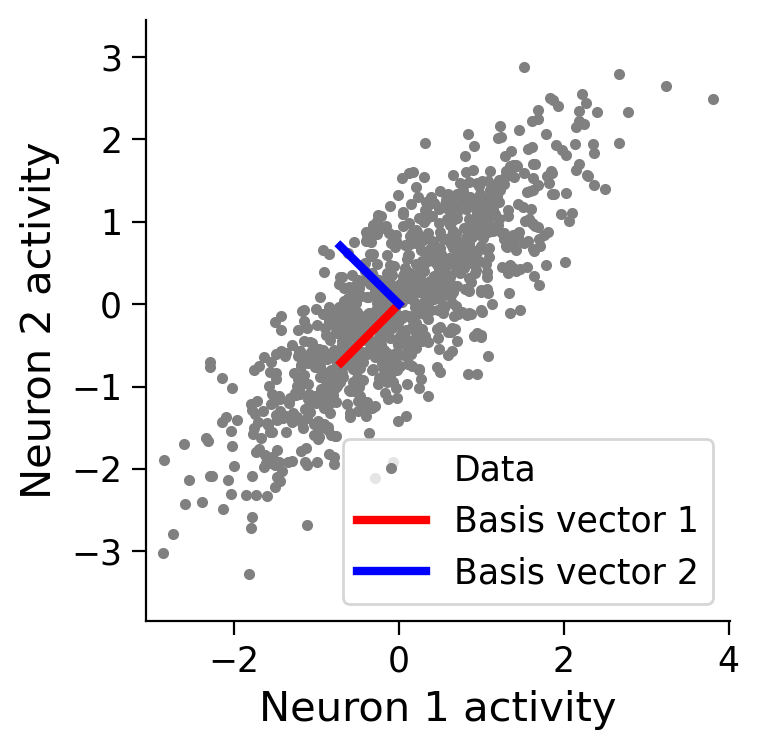

In [9]:
# Calculate the eigenvalues and eigenvectors
evals, evectors = np.linalg.eig(sample_cov_matrix)

# Sort the eigenvalues in descending order
idx = evals.argsort()[::-1]
evals = evals[idx],
evectors = evectors[:, idx]

# Visualize
plot_basis_vectors(X, evectors)

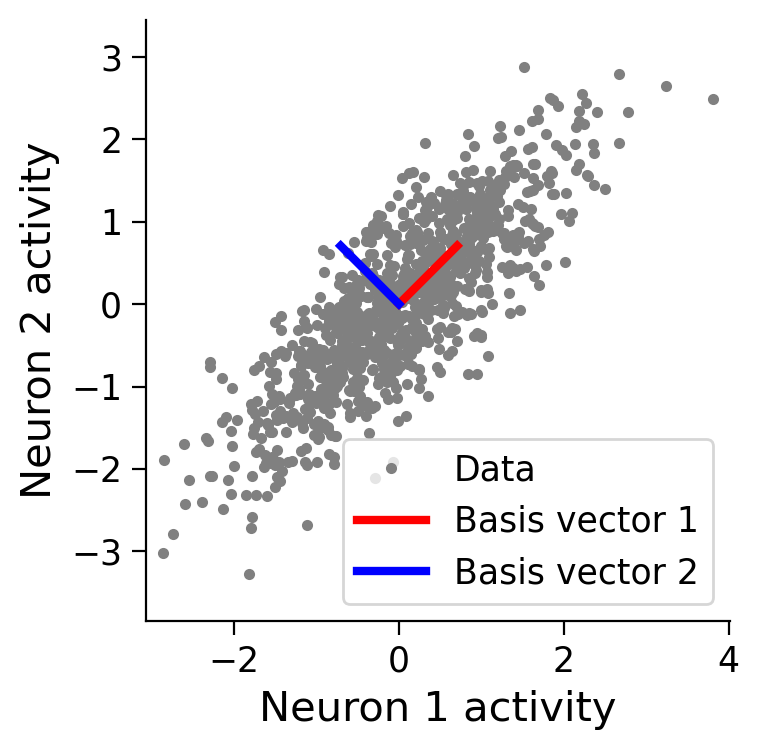

In [10]:
#Other method with defined helper function
# Calculate the eigenvalues and eigenvectors
evals, evectors = np.linalg.eigh(cov_matrix)

# Sort the eigenvalues in descending order
evals, evectors = sort_evals_descending(evals, evectors)

# Visualize
plot_basis_vectors(X, evectors)

## Perform PCA by projecting data onto the eigenvectors
To perform PCA, we project the data onto the eigenvectors of the covariance matrix
$
\begin{equation}
\bf S = X W
\end{equation}
$
Where S is an N by N matrix representing the projecte data (also called scores), and W is an N by N orthogonal matrix, each of whose columns represents the eigenvectors of the covariance matrix(also called weights or loadings)

In [11]:
help(change_of_basis)

Help on function change_of_basis in module __main__:

change_of_basis(X, W)
    Projects data onto a new basis.
    
    Args:
      X (numpy array of floats) : Data matrix each column corresponding to a
                                  different random variable
      W (numpy array of floats) : new orthonormal basis columns correspond to
                                  basis vectors
    
    Returns:
      (numpy array of floats)   : Data matrix expressed in new basis



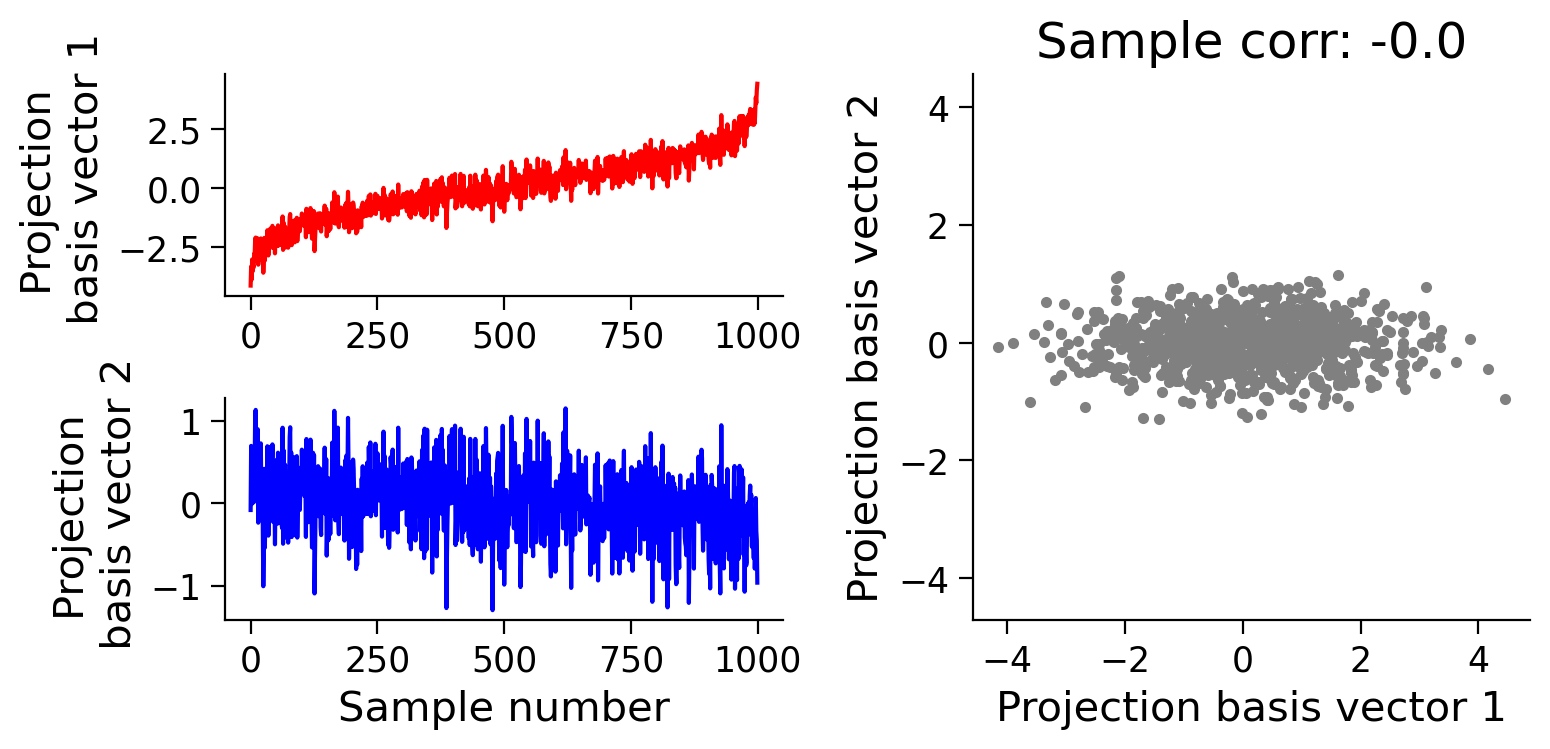

In [15]:
def pca(X):
  """
  Sorts eigenvalues and eigenvectors in decreasing order.

  Args:
    X (numpy array of floats): Data matrix each column corresponds to a
                               different random variable

  Returns:
    (numpy array of floats)  : Data projected onto the new basis
    (numpy array of floats)  : Vector of eigenvalues
    (numpy array of floats)  : Corresponding matrix of eigenvectors

  """



  # Calculate the sample covariance matrix
  cov_matrix = get_sample_cov_matrix(X)

  # Calculate the eigenvalues and eigenvectors
  evals, evectors = np.linalg.eig(cov_matrix)

  # Sort the eigenvalues in descending order
  evals, evectors = sort_evals_descending(evals, evectors)

  # Project the data onto the new eigenvector basis
  score = change_of_basis(X, evectors)

  return score, evectors, evals


# Perform PCA on the data matrix X
score, evectors, evals = pca(X)

# Plot the data projected into the new basis
plot_data_new_basis(score)

### Interesting Facts
1. As the absolute value of the correlation coefficient decreases the two eigenvalues become more similar (closer in value)
2. The two eigenvalues are extremely similar (basically equal) with a correlation coefficient of 0.
3. A correlation coefficent of 1 or -1 results in only one non-zero eigenvalue.